<a href="https://colab.research.google.com/github/Itskindastrange/House-Price-Predection/blob/main/House_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import copy
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [27]:
df = pd.read_csv('data.csv')
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [28]:
df = df.drop(['date' , 'sqft_living' , 'sqft_above' , 'statezip' , 'country'], axis=1)


In [29]:
#renaming sqft_basement to basement only and letting that it only tells if there is a basement or not instead of sqft
df = df.rename(columns={'sqft_basement' : 'basement'})
df['basement'] = df['basement'].apply(lambda x: 1 if x > 0 else 0)
df.head(2)

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,basement,yr_built,yr_renovated,street,city
0,313000.0,3.0,1.5,7912,1.5,0,0,3,0,1955,2005,18810 Densmore Ave N,Shoreline
1,2384000.0,5.0,2.5,9050,2.0,0,4,5,1,1921,0,709 W Blaine St,Seattle


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         4600 non-null   float64
 1   bedrooms      4600 non-null   float64
 2   bathrooms     4600 non-null   float64
 3   sqft_lot      4600 non-null   int64  
 4   floors        4600 non-null   float64
 5   waterfront    4600 non-null   int64  
 6   view          4600 non-null   int64  
 7   condition     4600 non-null   int64  
 8   basement      4600 non-null   int64  
 9   yr_built      4600 non-null   int64  
 10  yr_renovated  4600 non-null   int64  
 11  street        4600 non-null   object 
 12  city          4600 non-null   object 
dtypes: float64(4), int64(7), object(2)
memory usage: 467.3+ KB


In [31]:
df.isnull().sum()

price           0
bedrooms        0
bathrooms       0
sqft_lot        0
floors          0
waterfront      0
view            0
condition       0
basement        0
yr_built        0
yr_renovated    0
street          0
city            0
dtype: int64

In [32]:
df['price'].describe()


count    4.600000e+03
mean     5.519630e+05
std      5.638347e+05
min      0.000000e+00
25%      3.228750e+05
50%      4.609435e+05
75%      6.549625e+05
max      2.659000e+07
Name: price, dtype: float64

In [34]:
#one hot encoding
df_encoded = pd.get_dummies(df, columns=['city'])
df_encoded.head()


,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,basement,yr_built,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,313000.0,3.0,1.50,7912,1.5,0,0,3,0,1955,...,False,False,True,False,False,False,False,False,False,False
1,2384000.0,5.0,2.50,9050,2.0,0,4,5,1,1921,...,False,True,False,False,False,False,False,False,False,False
2,342000.0,3.0,2.00,11947,1.0,0,0,4,0,1966,...,False,False,False,False,False,False,False,False,False,False
3,420000.0,3.0,2.25,8030,1.0,0,0,4,1,1963,...,False,False,False,False,False,False,False,False,False,False
4,550000.0,4.0,2.50,10500,1.0,0,0,4,1,1976,...,False,False,False,False,False,False,False,False,False,False


In [35]:
for col in df_encoded.columns:
  if col.startswith('city_'):
    df_encoded[col] = df_encoded[col].astype(int)

df_encoded.head()


,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,basement,yr_built,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,313000.0,3.0,1.50,7912,1.5,0,0,3,0,1955,...,0,0,1,0,0,0,0,0,0,0
1,2384000.0,5.0,2.50,9050,2.0,0,4,5,1,1921,...,0,1,0,0,0,0,0,0,0,0
2,342000.0,3.0,2.00,11947,1.0,0,0,4,0,1966,...,0,0,0,0,0,0,0,0,0,0
3,420000.0,3.0,2.25,8030,1.0,0,0,4,1,1963,...,0,0,0,0,0,0,0,0,0,0
4,550000.0,4.0,2.50,10500,1.0,0,0,4,1,1976,...,0,0,0,0,0,0,0,0,0,0


In [40]:
for col in df_encoded.columns:
  if col == 'floors':
    df_encoded[col] = df_encoded[col].astype(int)
  elif col == "bathrooms":
    df_encoded[col] = df_encoded[col].astype(int)

df_encoded.head()

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,basement,yr_built,...,city_SeaTac,city_Seattle,city_Shoreline,city_Skykomish,city_Snoqualmie,city_Snoqualmie Pass,city_Tukwila,city_Vashon,city_Woodinville,city_Yarrow Point
0,313000.0,3.0,1,7912,1,0,0,3,0,1955,...,0,0,1,0,0,0,0,0,0,0
1,2384000.0,5.0,2,9050,2,0,4,5,1,1921,...,0,1,0,0,0,0,0,0,0,0
2,342000.0,3.0,2,11947,1,0,0,4,0,1966,...,0,0,0,0,0,0,0,0,0,0
3,420000.0,3.0,2,8030,1,0,0,4,1,1963,...,0,0,0,0,0,0,0,0,0,0
4,550000.0,4.0,2,10500,1,0,0,4,1,1976,...,0,0,0,0,0,0,0,0,0,0


In [68]:
df_encoded.drop(['street'], axis=1, inplace=True)

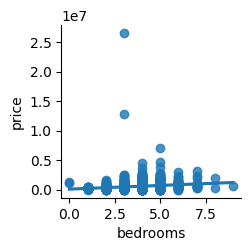

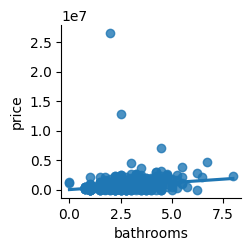

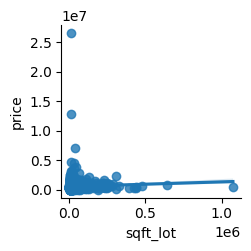

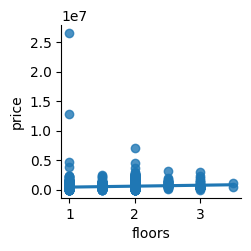

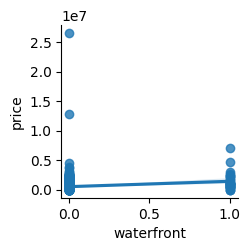

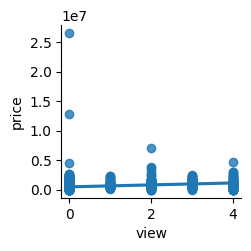

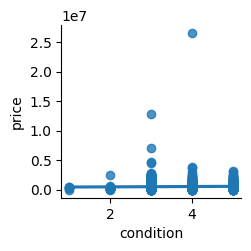

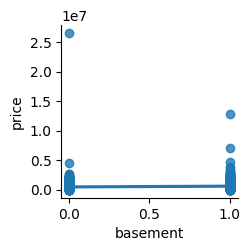

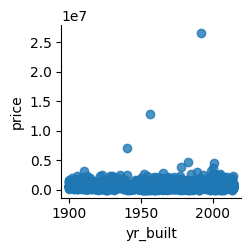

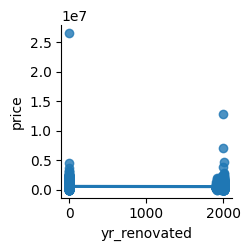

In [36]:
for col in df.columns[1:]:
    if df[col].dtype != 'object':
        sns.pairplot(df, x_vars=col, y_vars='price', kind='reg')
        plt.show()


In [56]:
# for i in range(len(df_encoded.columns)):
#     for j in range(i+1, len(df_encoded.columns)):
#         x_label = df_encoded.columns[i]
#         y_label = df_encoded.columns[j]

#         exclude_columns = ['street'] + [col for col in df_encoded.columns if col.startswith('city_')]


#         for column in df_encoded.columns:
#             if column not in exclude_columns and column != 'price':
#                 sns.scatterplot(x=column, y='price', data=df_encoded)
#                 plt.title(f"{column} vs price")
#                 plt.show()

# Train Test Val Datasets

In [69]:
train,valid,test=np.split(df_encoded.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

In [57]:
def get_xy(dataframe,y_label,x_labels=None):
  dataframe=copy.deepcopy(dataframe)
  if  x_labels is None:
    X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels)==1:
      X=dataframe[x_labels[0]].values.reshape(-1,1)
    else:
      X=dataframe[x_labels].values

  y=dataframe[y_label].values.reshape(-1,1)
  data=np.hstack((X,y))
  return data,X,y

In [70]:
df_encoded.columns[1:]

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'waterfront', 'view',
       'condition', 'basement', 'yr_built', 'yr_renovated', 'city_Algona',
       'city_Auburn', 'city_Beaux Arts Village', 'city_Bellevue',
       'city_Black Diamond', 'city_Bothell', 'city_Burien', 'city_Carnation',
       'city_Clyde Hill', 'city_Covington', 'city_Des Moines', 'city_Duvall',
       'city_Enumclaw', 'city_Fall City', 'city_Federal Way',
       'city_Inglewood-Finn Hill', 'city_Issaquah', 'city_Kenmore',
       'city_Kent', 'city_Kirkland', 'city_Lake Forest Park',
       'city_Maple Valley', 'city_Medina', 'city_Mercer Island', 'city_Milton',
       'city_Newcastle', 'city_Normandy Park', 'city_North Bend',
       'city_Pacific', 'city_Preston', 'city_Ravensdale', 'city_Redmond',
       'city_Renton', 'city_Sammamish', 'city_SeaTac', 'city_Seattle',
       'city_Shoreline', 'city_Skykomish', 'city_Snoqualmie',
       'city_Snoqualmie Pass', 'city_Tukwila', 'city_Vashon',
       'city_Woodinv

In [71]:
_ , X_train , y_train = get_xy(train,"price",x_labels=df_encoded.columns[1:])
_ , X_val , y_val = get_xy(valid,"price",x_labels=df_encoded.columns[1:])
_ , X_test , y_test = get_xy(test,"price",x_labels=df_encoded.columns[1:])


In [74]:
#without any SC
lr_model = LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [76]:
lr_model.score(X_train,y_train)

0.37424349006904145

In [84]:
y_pred = lr_model.predict(X_test)

print(f"Mean Abs Err: ", mean_absolute_error(y_test, y_pred))
print(f"Mean Sq Err: ",mean_squared_error(y_test, y_pred))
print(f"Root MSE: ",np.sqrt(mean_squared_error(y_test, y_pred)))
print(f"R^2: ",r2_score(y_test, y_pred))




Mean Abs Err:  154416.4257488123
Mean Sq Err:  70908141752.53687
Root MSE:  266285.82717173826
R^2:  0.4734057853162469
